In [28]:
"""
Residents per residential building.
Calculations based on population and building grid data provided by Helsinki Region Environmental Services HSY.

Author: Tarja Turunen, 6.12.2021
"""

import geopandas as gpd
import pandas as pd
from pyproj import CRS
import matplotlib.pyplot as plt
import mapclassify
import numpy as np
import contextily as ctx

In [29]:
# file paths
fp_population = r"data/Vaestotietoruudukko_2020.geojson"
fp_buildings = r"data/Rakennustietoruudukko_2020.geojson"
fp_stations = r"data/asemat.geojson"

# importing data
population = gpd.read_file(fp_population, driver="GeoJSON")
buildings = gpd.read_file(fp_buildings, driver="GeoJSON")
stations = gpd.read_file(fp_stations, driver="GeoJSON")

# asserting same crs for tree data
assert population.crs == buildings.crs == stations.crs, "All data must have the same crs"

In [30]:
# subset data
population = population[["index", "asukkaita", "geometry"]]
buildings = buildings[["index", "raklkm_as", "geometry"]]

# rename columns
population.rename(columns={"asukkaita":"population"}, inplace=True)
buildings.rename(columns={"raklkm_as":"res_buildings"}, inplace=True)

In [31]:
# merge data (both have the same grid and indexing, merge can be done on index column)
merged = pd.merge(population, buildings, on="index")

In [32]:
# keeping only one geometry
merged = merged[["index", "geometry_x", "population", "res_buildings"]]

# rename columns
merged.rename(columns={"geometry_x":"geometry"}, inplace=True)

In [33]:
# calculating people/building in new column
merged["pop_per_building"] = (merged["population"]/merged["res_buildings"]).round(0)

# replacing inf values with 999999
#merged["pop_per_building"] = merged["pop_per_building"].replace(np.inf, 9999)

# dropping inf value
merged = merged.loc[merged["pop_per_building"] != np.inf]

In [34]:
# converting dataframe to a geodataframe
merged = gpd.GeoDataFrame(merged, crs=population.crs, geometry=merged["geometry"])

In [35]:
# reproject to Web Mercator for matching with the basemap
merged = merged.to_crs(epsg=3857)
stations = stations.to_crs(epsg=3857)

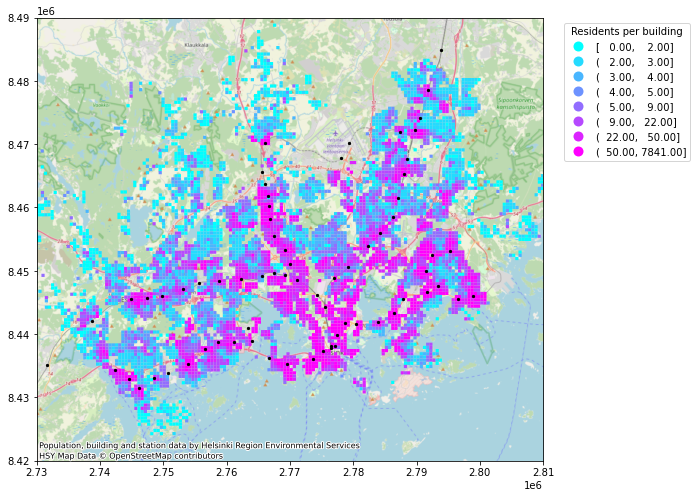

In [40]:
# set up the figure
fig, ax = plt.subplots(figsize=(10,10))

# plot data
merged.plot(ax=ax, column="pop_per_building", figsize=(20,10), cmap="cool", legend=True, scheme="quantiles", k=8)

# add stations
stations.plot(ax=ax, color="black", markersize=5)

# credits
credits = "Population, building and station data by Helsinki Region Environmental Services \nHSY Map Data © OpenStreetMap contributors"

# add basemap
ctx.add_basemap(ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik)

# legend
ax.get_legend().set_bbox_to_anchor((1.3,1))
ax.get_legend().set_title("Residents per building")

# crop the figure
ax.set_xlim(2730000, 2810000)
ax.set_ylim(8420000, 8490000)

# tight layout
plt.tight_layout()

# output file path
fp_output = r"docs/residents_per_building.png"

# save figure in file
plt.savefig(fp_output, dpi=300)

<Figure size 432x288 with 0 Axes>